# 🏯 Архитектуры сверточных нейронных сетей 🏯

Рассмотрим основные архитектуры сверточных нейронных сетей с чего начиналось и как они эволюционировали.
Эти модели могут использоваться по разному: для классификации или для извлечения признаков(детекция, сегментация, ...)

## Немного истории

### LeNet (Yann LeCun(Bell Labs, now Meta) et al. in 1989)
Первое успешное применение обратного распространения на практике.
Задача - распознавание рукописных цифр zip-кода для почты США.

Архитектура:
2 - conv(kernel=5x5), 2 - padding(stride=2), 3 - FC  
https://russianblogs.com/article/71181560328/

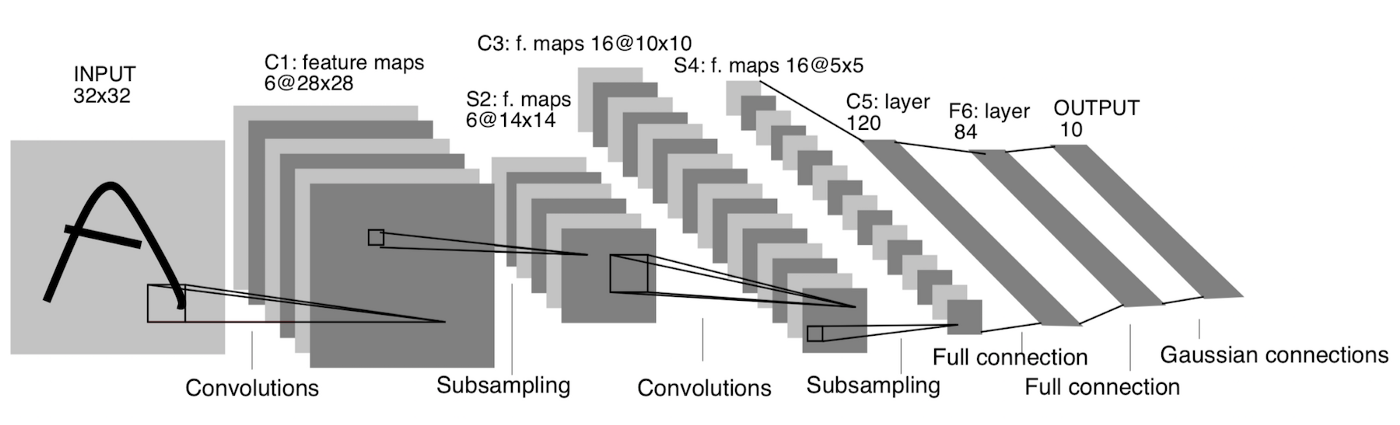

In [ ]:
import torch
from torch import nn

le_net = nn.Sequential(
    nn.Conv2d(1, 6, kernel_size=5, padding=2), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Conv2d(6, 16, kernel_size=5), 
    nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(16 * 5 * 5, 120), 
    nn.Sigmoid(),
    nn.Linear(120, 84), 
    nn.Sigmoid(),
    nn.Linear(84, 10),
)

## [AlexNet](https://proceedings.neurips.cc/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)(Alex Krizhevsky, Ilya Sutskever and Geoffrey Hinton, 2012)

Классификация изображений (1000 классов), задача [Imagenet](https://www.image-net.org/).

* ReLU Nonlinearity
* Multiple GPUs

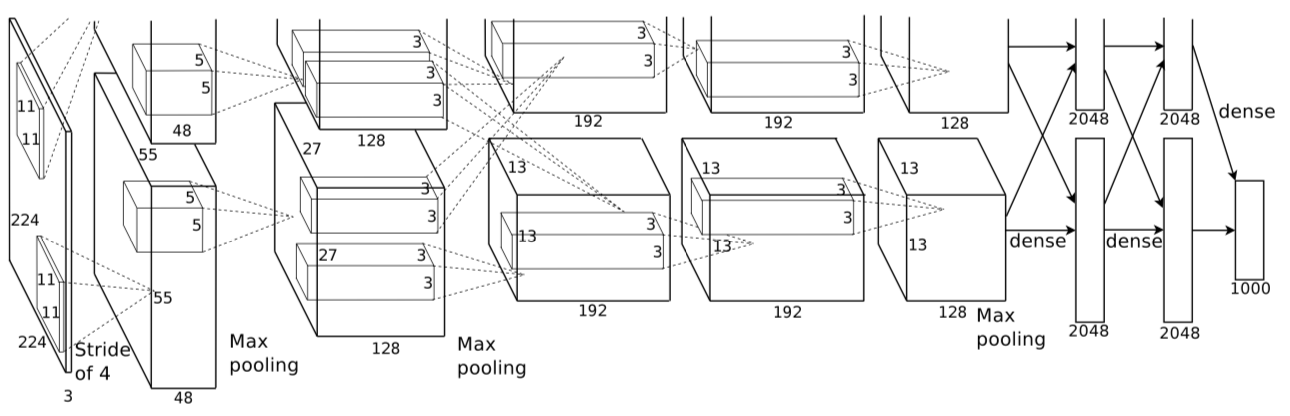

https://neurohive.io/ru/vidy-nejrosetej/alexnet-svjortochnaja-nejronnaja-set-dlja-raspoznavanija-izobrazhenij/

In [ ]:
alex_net = nn.Sequential(
    # Here, we use a larger 11 x 11 window to capture objects. At the same
    # time, we use a stride of 4 to greatly reduce the height and width of the
    # output. Here, the number of output channels is much larger than that in
    # LeNet
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Make the convolution window smaller, set padding to 2 for consistent
    # height and width across the input and output, and increase the number of
    # output channels
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    # Use three successive convolutional layers and a smaller convolution
    # window. Except for the final convolutional layer, the number of output
    # channels is further increased. Pooling layers are not used to reduce the
    # height and width of input after the first two convolutional layers
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    # Here, the number of outputs of the fully-connected layer is several
    # times larger than that in LeNet. Use the dropout layer to mitigate
    # overfitting
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    # Output layer. Since we are using Fashion-MNIST, the number of classes is
    # 10, instead of 1000 as in the paper
    nn.Linear(4096, 10),
)

In [ ]:
import torchvision.models as models
alex_net = models.alexnet(pretrained=True, num_classes=1000) 

# Если нужно другое количество классов, то
new_num_classes = 128
alex_net[-1] = nn.Linear(alex_net[-1].in_features, new_num_classes)

## [VGG](https://arxiv.org/abs/1409.1556) (Karen Simonyan, Andrew Zisserman, 2014)

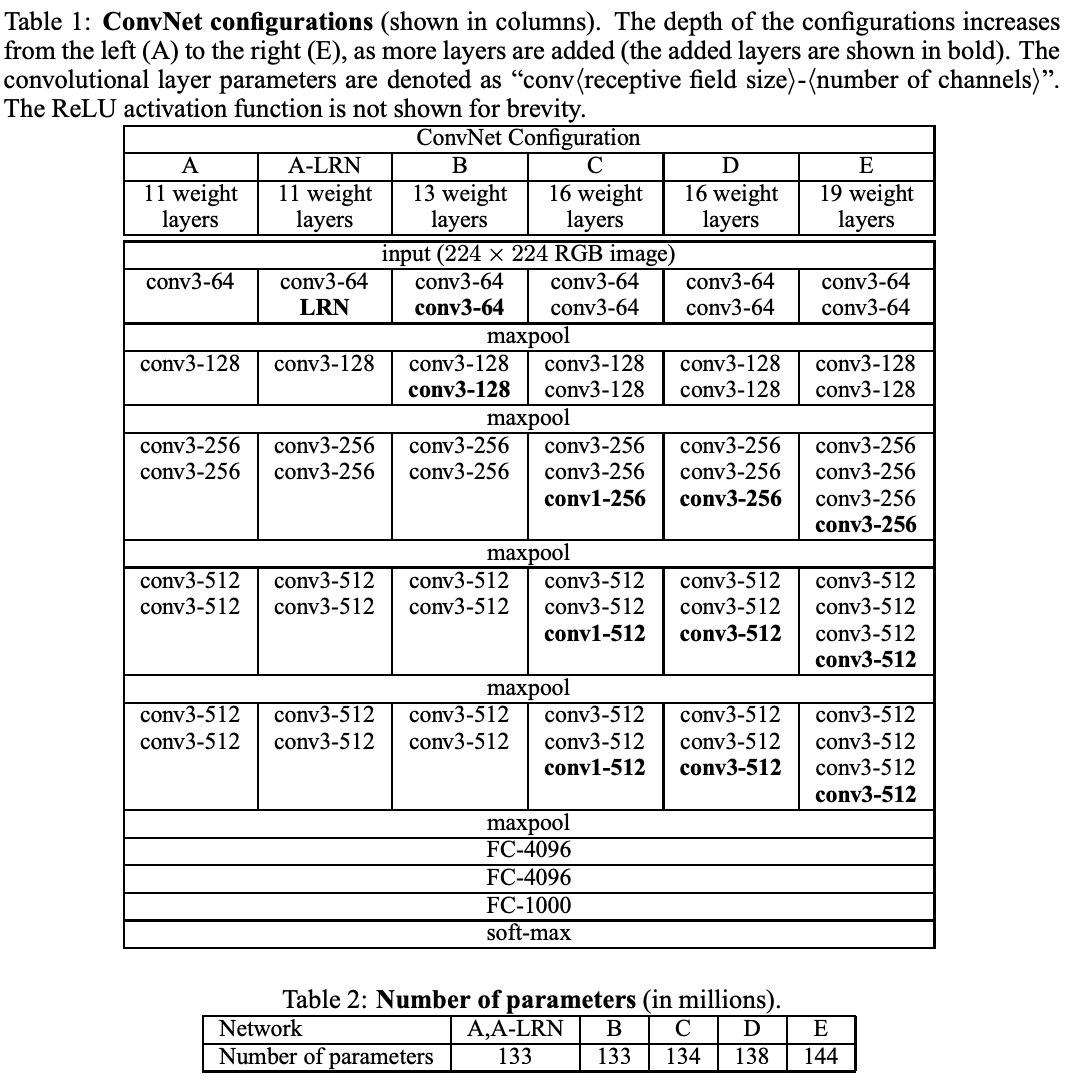

https://neurohive.io/ru/vidy-nejrosetej/vgg16-model/  
https://russianblogs.com/article/3773549397/  
https://towardsdatascience.com/vgg-neural-networks-the-next-step-after-alexnet-3f91fa9ffe2c  

In [ ]:
def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [ ]:
def vgg(conv_arch):
    conv_blks = []
    in_channels = 1
    # The convolutional part
    for (num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(),
        # The fully-connected part
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10))

net = vgg(conv_arch)

In [ ]:
import torchvision.models as models
alex_net = models.vgg11(pretrained=True, num_classes=1000) 

## [GoogLeNet (Inception V1, 2014)](https://arxiv.org/abs/1409.4842)  
Идея - давайте использовать на каждом слое различные размеры ядер, чтобы получать различную пространственную информацию (3 свертки 1x1, 3x3, 5x5). Для уменьшения вычислительной сложности перед свертками 3x3 и 5x5 поставим свертку 1x1 которая будет уменьшать количество каналов. Последний, четвертый, путь - макс пуллинг за которым идет свертка 1x1 для смены количества каналов. Все пути используют паддинги чтобы входы и выходы имели одинаковые пространственные разрешения.

Давайте перед каждым свёрточным блоком делать свёртку с размером ядра 1х1, снижая размерность сигнала, подающегося на вход свёрткам с большими размерами ядер.

Polling нужны для :
* уменьшение изображения, чтобы последующие свертки оперировали над большей областью исходного изображения;
* увеличение инвариантности выхода сети по отношению к малому переносу входа;
* ускорение вычислений.

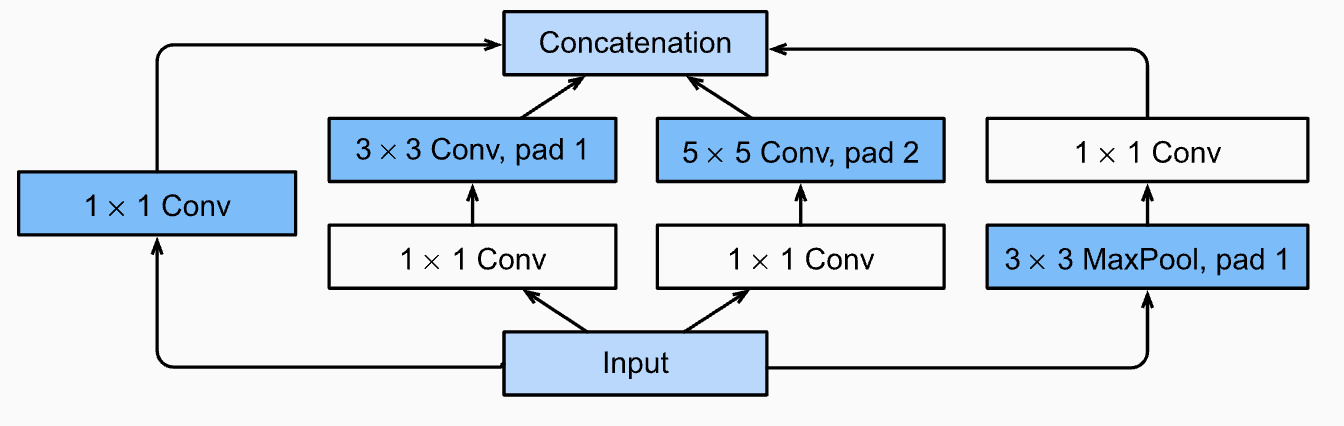

https://habr.com/ru/post/301084/  


In [ ]:
class Inception(nn.Module):
    # `c1`--`c4` are the number of output channels for each path
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # Path 1 is a single 1 x 1 convolutional layer
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # Path 2 is a 1 x 1 convolutional layer followed by a 3 x 3
        # convolutional layer
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # Path 3 is a 1 x 1 convolutional layer followed by a 5 x 5
        # convolutional layer
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # Path 4 is a 3 x 3 maximum pooling layer followed by a 1 x 1
        # convolutional layer
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # Concatenate the outputs on the channel dimension
        return torch.cat((p1, p2, p3, p4), dim=1)

# [Depthwise separable (Xception, 2017)](https://arxiv.org/pdf/1610.02357.pdf)

Представим, что мы взяли стандартный свёрточный слой с $C_2$ фильтрами размера 3х3, на вход которому подается тензор размерности $M*M*C_1$, где $M$ — это ширина и высота тензора, а $C_1$ — количество каналов.
Что делает такой слой? Он сворачивает одновременно все каналы исходного сигнала $C_2$ разными свёртками. На выходе у такого слоя получается тензор размерности $(M - 2)*(M - 2)*C_2$.

Давайте вместо этого сделаем последовательно два шага:

* Свернём исходный тензор 1х1 свёрткой, подобно тому как мы делали в блоке Inception, получив тензор $M*M*C_2$. Эта операция называется pointwise convolution
* Свернём каждый канал по отдельности 3х3 свёрткой (при этом размерность не изменится, так как мы сворачиваем не все каналы вместе, как в обычном свёрточном слое). Эта операция называется depthwise spatial convolution  

Однако, под DWS(depthwise separable convolution) обычно понимают сначала свертку по каналам, а потм уже по пиксельная

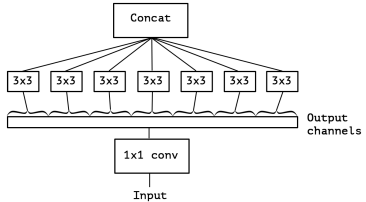
[Ссылка](https://habr.com/ru/post/347564/)

Пусть мы сворачиваем изображение с 16 каналами свёрточным слоем с 32 фильтрами. Суммарно этот свёрточный слой будет иметь $16*32*3*3=4608$ весов, так как у нас будет $16*32$ свёрток 3х3.

Сколько же весов будет в аналогичном depthwise separable convolution блоке? Во-первых, у нас будет $16*32*1*1=512$ весов у pointwise convolution. Во-вторых, у нас будет $32*3*3=288$ весов у depthwise convolution. В сумме получим 800 весов.

Обычный свёрточный слой одновременно обрабатывает как пространственную информацию (корреляцию соседних точек внутри одного канала), так и межканальную информацию, так как свёртка применяется ко всем каналам сразу. Архитектура Xception базируется на предположении о том, что эти два вида информации можно обрабатывать последовательно без потери качества работы сети, и раскладывает обычную свёртку на pointwise convolution (которая обрабатывает только межканальную корреляцию) и spatial convolution (которая обрабатывает только пространственную корреляцию в рамках отдельного канала).

# [MobileNet (2017)](https://arxiv.org/pdf/1704.04861.pdf) and [MobileNet V2 (2019)](https://arxiv.org/pdf/1801.04381.pdf)
https://habr.com/ru/post/352804/

### MobileNetV1

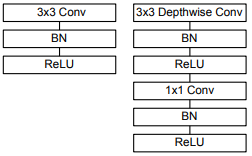

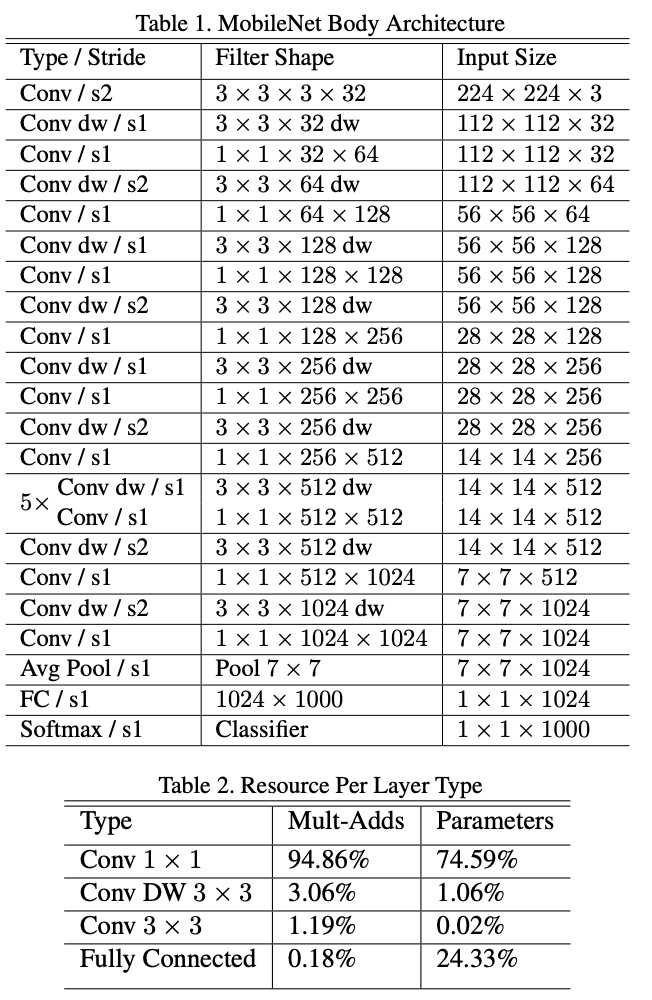

Особенностью данной архитектуры является отсутствие max pooling-слоёв. Вместо них для снижения пространственной размерности используется свёртка с параметром stride, равным 2.

Двумя гиперпараметрами архитектуры MobileNet являются $\alpha$ (множитель ширины) и $\rho$ (множитель глубины или множитель разрешения).

Множитель ширины отвечает за количество каналов в каждом слое. Например, $\alpha = 1$ даёт нам архитектуру, описанную в статье, а $\alpha = 0.25$ — архитектуру с уменьшенным в четыре раза числом каналов на выходе каждого блока.

Множитель разрешения отвечает за пространственные размеры входных тензоров. Например, $\rho= 0.5$ означает, что высота и ширина feature map, подаваемой на вход каждому слою будет уменьшена вдвое.

### MobileNetV2

#### Expansion convolution block или bottleneck convolution block with expansion layer

1. Сначала идёт pointwise convolution с большим количеством каналов, называемый expansion layer.

На входе этот слой принимает тензор размерности $D_f * D_f * C_{in}$, а на выходе выдает тензор $D_f * D_f * (t*C_{in})$, где $t$ — новый гиперпараметр, названный уровнем расширения (в оригинале expansion factor). Авторы рекомендуют задавать этому гиперпараметру значение от 5 до 10, где меньшие значения лучше работают для более маленьких сетей, а большие — для более крупных (в самой статье во всех экспериментах принимается $t = 6$).
Этот слой создает отображение входного тензора в пространстве большой размерности. Авторы называют такое отображение «целевым многообразием» (в оригинале «manifold of interest»)

2. Затем идёт depthwise convolution с ReLU6-активацией. 

Этот слой вместе с предыдущим по сути образует уже знакомый нам строительный блок MobileNetV1.
На входе этот слой принимает тензор размерности $D_f * D_f * (t*C_{in})$, а на выходе выдает тензор $(D_f/s) * (D_f/s) * (t*C_{in})$, где $s$ — шаг свертки (stride), ведь как мы помним, depthwise convolution не меняет число каналов.

3. В конце идёт 1х1-свертка с линейной функцией активации, понижающая число каналов. 

Авторы статьи выдвигают гипотезу, что «целевое многообразие» высокой размерности, полученное после предыдущих шагов, можно «уложить» в подпространство меньшей размерности без потери полезной информации, что, собственно и делается на этом шаге (как можно увидеть по экспериментальным результатам, эта гипотеза полностью оправдывается).
На входе такой слой принимает тензор размерности $(D_f/s) * (D_f/s) * (t*C_{in})$, а на выходе выдает тензор $(D_f/s) * (D_f/s) * C_{out}$, где $C_{out}$ — количество каналов на выходе блока.

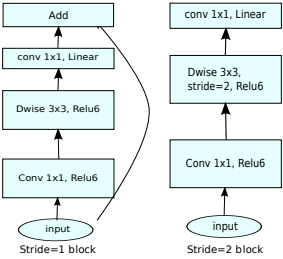

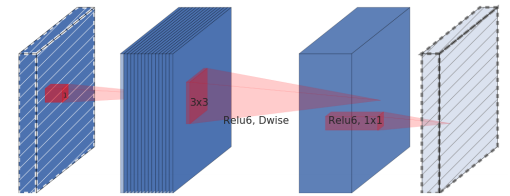

## [ResNet](https://arxiv.org/abs/1512.03385) (Kaiming He, Xiangyu Zhang, 2015)

Двумя серьезными проблемами в обучении глубоких нейронных сетей являются исчезающий градиент (англ. vanishing gradient) и взрывающийся градиент (англ. exploding gradient). Они возникают из-за того, что при дифференцировании по цепному правилу, до глубоких слоев нейронной сети доходит очень маленькая величина градиента (из-за многократного домножения на небольшие величины на предыдущих слоях).

Также было замечено, что если просто стекать больше слоев, то качество такой модели растет до некоторого предела, а затем начинает падать. Эту проблему называют degradation problem.  

Пусть мы взяли обученную сеть и застекали еще слоев, мы ожидаем, что такая сеть будет работать не хуже своего 'младшего' брата. Если обученная сеть уже достигла предела точности, то мы ожидаем, что добавленные слои будут представлять собой тождественное преобразование, однако во время тренировки получить такое тождественное преобразование не получается.

Давайте добавим shortcut-соединение, тогда вместо того чтобы оптимихатор старался получить тождественное преобразование, ему проще будет занулить веса.

1 × 1 свертки эксплуатируются для увеличения и уменьшения размерности, как и завещал гугл. Сеть является fully convolution.

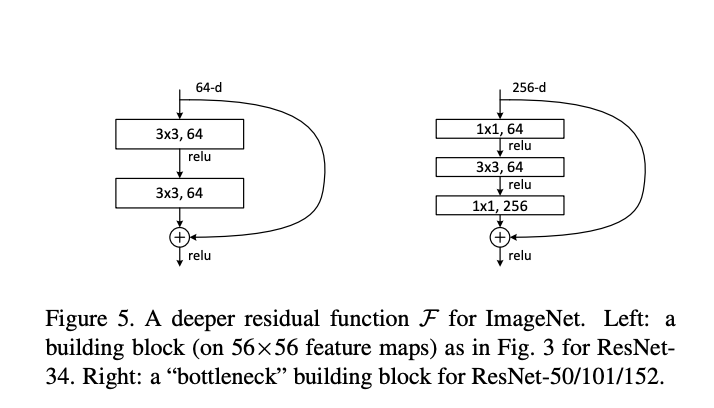

Кроме того у плоской сети формула градиента состоит из серии матрично-векторных произведений, что при увеличении количества слоев будет приводить к проблеме затухания градиентов. При этом в resnet если продифференцировать целевую функцию по какому-либо слою k, то получим, что градиент декомпозируется в сумму двух членов: производной целевой функции по последнему слою и суммы частных производных.  И градиент целевой функции доходит до каждого слоя внутри сети, что сильно уменьшает вероятность затухания градиентов и позволяет обучать сверхглубокие сети.

Архитектуры ResNet в зависимости от глубины.

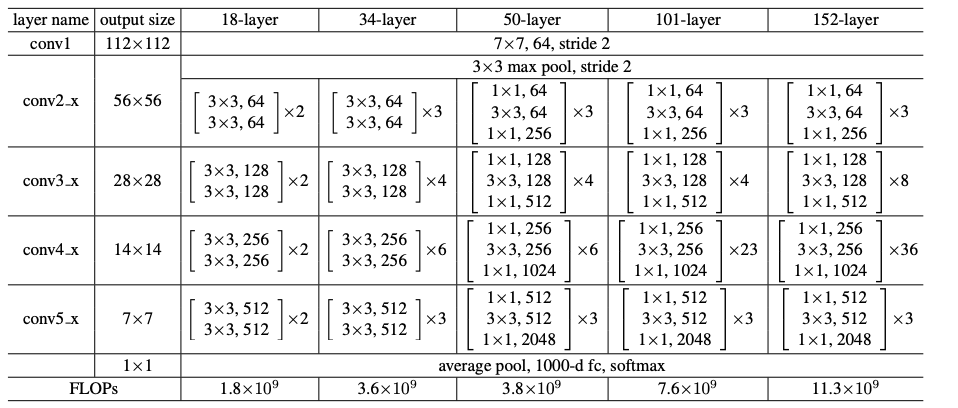

https://habr.com/ru/company/vk/blog/311706/